## Introduction

### Jakarta Selatan - Stasiun Jagakarsa  
**Koordinat Geospasial:** 106.80367, -6.35693  

Jakarta merupakan salah satu kota metropolitan dengan tingkat aktivitas ekonomi, transportasi, dan urbanisasi yang sangat tinggi. Salah satu titik representatif di pusat kota adalah **Jagakarsa**, yang berfungsi sebagai area observasi penting untuk memantau dinamika kualitas udara di kawasan perkotaan padat penduduk.

Dalam penelitian ini, digunakan **model Long Short-Term Memory (LSTM)** — sebuah arsitektur jaringan saraf tiruan (neural network) berbasis *Recurrent Neural Network (RNN)* — untuk memprediksi variasi konsentrasi **PM2.5** dan parameter atmosfer seperti **Aerosol Optical Depth (AOD)**. Model LSTM dipilih karena kemampuannya dalam menangkap **pola temporal dan dependensi jangka panjang** dari data deret waktu (*time series*), yang umum ditemukan dalam dinamika atmosfer.

Secara konseptual, LSTM memiliki tiga gerbang utama:
1. **Forget Gate** – menentukan informasi mana yang perlu dihapus dari memori sel.
2. **Input Gate** – mengontrol seberapa banyak informasi baru akan disimpan.
3. **Output Gate** – mengatur keluaran dari memori sel ke langkah waktu berikutnya.

Dengan memanfaatkan data historis dari **satelit MODIS (MAIAC AOD)** dan **data pengamatan stasiun ISPU**, model LSTM diharapkan mampu memberikan prediksi yang lebih akurat terhadap variasi harian PM2.5 di wilayah Jagakarsa, serta membantu dalam analisis sumber polutan dan pola sebarannya.

---

### Tujuan Penelitian
- Menerapkan model LSTM untuk memprediksi konsentrasi PM2.5 berbasis data AOD dan variabel meteorologi.  
- Mengevaluasi performa model menggunakan metrik statistik seperti RMSE, MAE, MAPE, R², dan NSE.  
- Menganalisis keterkaitan spasial antara variabilitas AOD dengan dinamika polusi udara di Jakarta Pusat.  

---

### Ringkasan Teknis
| Komponen | Deskripsi |
|-----------|------------|
| **Model** | Long Short-Term Memory (LSTM) |
| **Input Data** | AOD (MODIS MCD19A2), Temperatur, Kelembapan, Kecepatan Angin, dll |
| **Output Target** | Konsentrasi PM2.5 Harian |
| **Periode Data** | 2022 – 2024 |
| **Lokasi Studi** | Jagakarsa (106.80367, -6.35693) |
| **Evaluasi Kinerja** | RMSE, MAE, MAPE, R², NSE |

---

### Gagasan Inti
Melalui pendekatan *deep learning* berbasis LSTM, penelitian ini berupaya membangun model prediktif yang tidak hanya mampu mengikuti pola temporal jangka pendek, tetapi juga menangkap *lag effect* antarvariabel atmosferik terhadap kualitas udara. Pendekatan ini diharapkan dapat memberikan kontribusi ilmiah terhadap **analisis sumber polutan PM2.5** dan **pemantauan kualitas udara perkotaan secara berkelanjutan**.


1. Importing Required Libraries   
- Mempersiapkan library yang diperlukan dalam pemrosesan data deret waktu dan pembangunan model LSTM.
- Memepersiapkan library untuk visualisasi utk mempermudah interpretasi data

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2. Data Cleaning and Interpolation
- Pada tahap ini dilakukan pembersihan data dengan mengganti nilai nol (`0`) dan simbol kosong (`-`) menjadi nilai hilang (`NaN`).  
- Proses interpolasi linier untuk memperkirakan nilai yang hilang pada variabel seperti *PM2.5*, suhu, kelembapan, kecepatan angin, curah hujan, dan AOD, sehingga menghasilkan dataset yang lebih lengkap dan siap digunakan untuk pemodelan LSTM.

In [5]:
path = "C:\\Users\\user\\OneDrive\\IPB\Thesis\\02. Development\\03. LSTM\\LSTM with Visualcrossing Himawari\\data\\jagakarsa.csv"
df_cleaned = pd.read_csv(path)
columns = ['ISPU PM2.5', 'temp', 'dew', 'humidity', 'windspeed', 'AOD'] # untuk nilai 0
for col in columns:
    df_cleaned.loc[df_cleaned[col] == 0, col] = pd.NA
    
df_cleaned.replace("-", pd.NA, inplace=True)

columns = ['ISPU PM2.5', 'temp', 'dew', 'humidity', 'windspeed', 'precip', 'AOD'] # untuk interpolasi
for col in columns:
    df_cleaned[col] = df_cleaned[col].interpolate(method='linear')

df_cleaned = df_cleaned.dropna()

df_cleaned

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\user\AppData\Local\Temp\ipykernel_32844\1267377309.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "C:\\Users\\user\\OneDrive\\IPB\Thesis\\02. Development\\03. LSTM\\LSTM with Visualcrossing Himawari\\data\\jagakarsa.csv"


,ISPU PM2.5,datetime,temp,dew,humidity,precip,windspeed,AOD
11,52.750000,2022-01-12,26.2,24.1,88.8,17.026,20.6,0.109585
12,54.666667,2022-01-13,26.9,24.1,85.6,5.949,24.1,0.110431
13,60.916667,2022-01-14,26.7,24.3,87.3,14.183,19.0,0.111277
14,68.833333,2022-01-15,26.7,24.3,87.2,5.342,16.6,0.112123
15,80.916667,2022-01-16,26.9,25.2,90.3,6.368,11.6,0.112969
...,...,...,...,...,...,...,...,...
1091,82.888889,2024-12-27,28.8,23.2,73.2,0.000,16.7,0.018800
1092,74.833333,2024-12-28,29.4,22.2,66.7,0.044,21.2,0.003000
1093,66.777778,2024-12-29,28.9,23.5,73.5,0.051,15.2,0.003000
1094,58.722222,2024-12-30,27.8,23.0,75.5,3.335,29.9,0.003000


In [6]:
print("\nData Information")
print("="*30)
df_cleaned.info()

print("\nData Summary")
print("="*30)
df_cleaned.isna().sum()
# df.duplicated().sum()


Data Information
<class 'pandas.core.frame.DataFrame'>
Index: 1085 entries, 11 to 1095
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ISPU PM2.5  1085 non-null   float64
 1   datetime    1085 non-null   object 
 2   temp        1085 non-null   float64
 3   dew         1085 non-null   float64
 4   humidity    1085 non-null   float64
 5   precip      1085 non-null   float64
 6   windspeed   1085 non-null   float64
 7   AOD         1085 non-null   float64
dtypes: float64(7), object(1)
memory usage: 76.3+ KB

Data Summary


ISPU PM2.5    0
datetime      0
temp          0
dew           0
humidity      0
precip        0
windspeed     0
AOD           0
dtype: int64

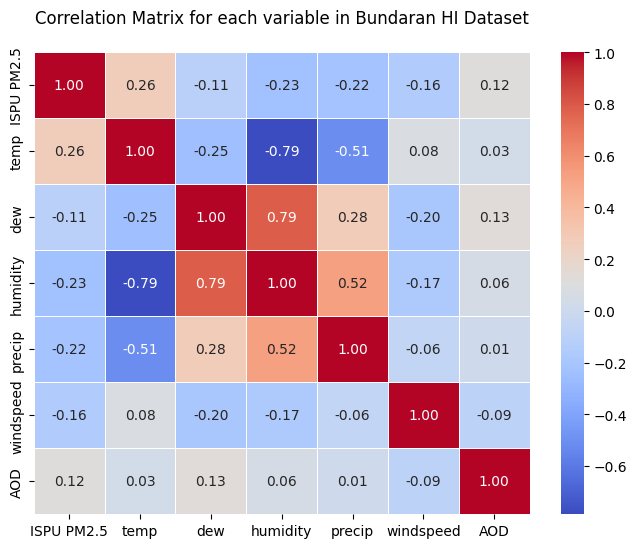

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# hanya ambil kolom numerik
corr = df_cleaned.select_dtypes(include=['number']).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix for each variable in Bundaran HI Dataset\n")
plt.show()


Top features by Pearson correlation: ['temp', 'humidity', 'precip', 'windspeed', 'AOD']
Top features by PCA loadings: ['humidity', 'dew', 'temp', 'precip', 'windspeed']

✅ Fitur terpilih untuk model: ['windspeed', 'humidity', 'dew', 'AOD', 'temp', 'precip']


C:\Users\user\AppData\Local\Temp\ipykernel_32844\4150998722.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series.abs().sort_values(ascending=False).values,


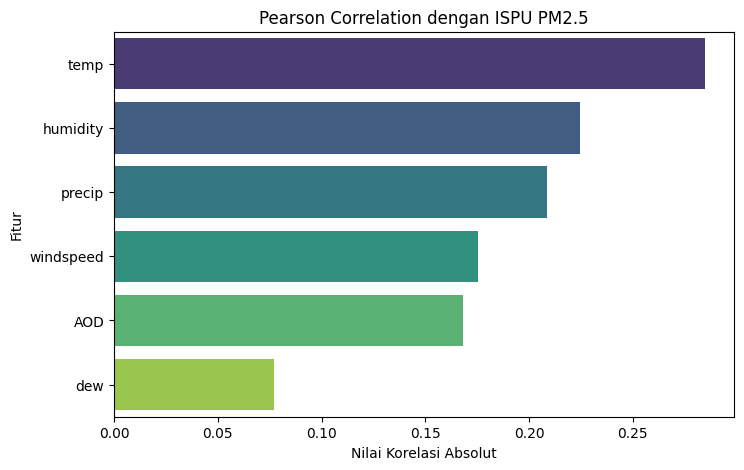

C:\Users\user\AppData\Local\Temp\ipykernel_32844\4150998722.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings['PC1'][i], loadings['PC2'][i], feature, fontsize=10)


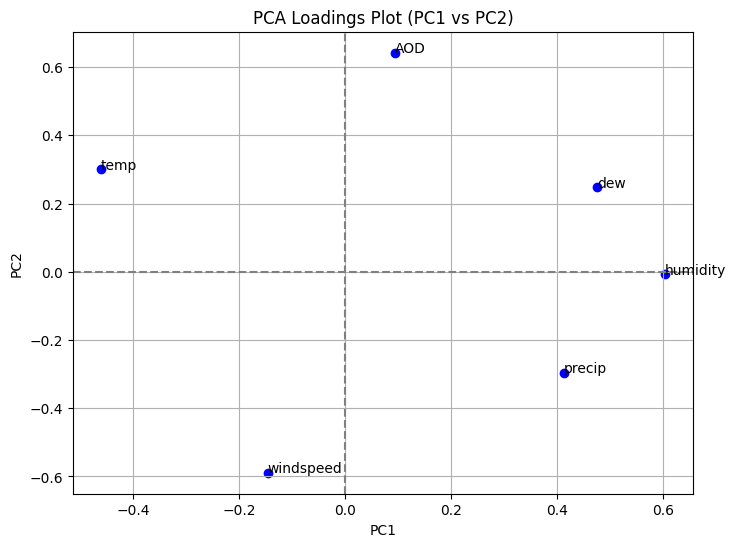

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1️⃣ Load data
df = pd.read_csv(path, parse_dates=['datetime'])
df.columns = df.columns.str.strip()

# 2️⃣ Pilih kolom numerik dan drop target untuk PCA
target_col = 'ISPU PM2.5'
df_num = df.select_dtypes(include=['number'])
features_only = df_num.drop(columns=[target_col])

# 3️⃣ Pearson Correlation dengan Target
corr_series = df_num.corr()[target_col].drop(target_col)
top_corr_features = corr_series.abs().sort_values(ascending=False).head(5).index.tolist()

print(f"Top features by Pearson correlation: {top_corr_features}")

# 4️⃣ PCA (sebagai PPCA simplifikasi)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_only.dropna())  # Hapus NaN dulu

pca = PCA(n_components=2)
pca.fit(X_scaled)

# Loadings
loadings = pd.DataFrame(pca.components_.T, 
                        index=features_only.columns, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Ambil fitur dengan loading tertinggi (komponen 1)
top_pca_features = loadings['PC1'].abs().sort_values(ascending=False).head(5).index.tolist()

print(f"Top features by PCA loadings: {top_pca_features}")

# 5️⃣ Gabungkan hasil Pearson + PCA
final_features = list(set(top_corr_features + top_pca_features))
print(f"\n✅ Fitur terpilih untuk model: {final_features}")

import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Pearson correlation dengan target
plt.figure(figsize=(8,5))
sns.barplot(x=corr_series.abs().sort_values(ascending=False).values, 
            y=corr_series.abs().sort_values(ascending=False).index, palette='viridis')
plt.title('Pearson Correlation dengan ISPU PM2.5')
plt.xlabel('Nilai Korelasi Absolut')
plt.ylabel('Fitur')
plt.show()

# 2️⃣ PCA Loadings
plt.figure(figsize=(8,6))
plt.scatter(loadings['PC1'], loadings['PC2'], c='blue')

for i, feature in enumerate(loadings.index):
    plt.text(loadings['PC1'][i], loadings['PC2'][i], feature, fontsize=10)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.title('PCA Loadings Plot (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

In [10]:
df_cleaned

,ISPU PM2.5,datetime,temp,dew,humidity,precip,windspeed,AOD
11,52.750000,2022-01-12,26.2,24.1,88.8,17.026,20.6,0.109585
12,54.666667,2022-01-13,26.9,24.1,85.6,5.949,24.1,0.110431
13,60.916667,2022-01-14,26.7,24.3,87.3,14.183,19.0,0.111277
14,68.833333,2022-01-15,26.7,24.3,87.2,5.342,16.6,0.112123
15,80.916667,2022-01-16,26.9,25.2,90.3,6.368,11.6,0.112969
...,...,...,...,...,...,...,...,...
1091,82.888889,2024-12-27,28.8,23.2,73.2,0.000,16.7,0.018800
1092,74.833333,2024-12-28,29.4,22.2,66.7,0.044,21.2,0.003000
1093,66.777778,2024-12-29,28.9,23.5,73.5,0.051,15.2,0.003000
1094,58.722222,2024-12-30,27.8,23.0,75.5,3.335,29.9,0.003000


In [13]:
df = df_cleaned

features = ["temp", "dew", "humidity", "precip", "windspeed", "AOD", "ISPU PM2.5"]
target = "ISPU PM2.5"

# Normalisasi data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Tentukan lookback (jumlah timestep sebelumnya digunakan untuk prediksi)
lookback = 30

# Bagi data menjadi training (70%), validasi (15%), dan testing (15%)
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.15)

train_data = df_scaled[:train_size]
val_data = df_scaled[train_size:train_size+val_size]
test_data = df_scaled[train_size+val_size:]

# Gunakan TimeseriesGenerator untuk membentuk data dalam format sekuensial
train_gen = TimeseriesGenerator(train_data, train_data[:, 6], length=lookback, batch_size=4)
val_gen = TimeseriesGenerator(val_data, val_data[:, 6], length=lookback, batch_size=4)
test_gen = TimeseriesGenerator(test_data, test_data[:, 6], length=lookback, batch_size=4)

# Cek bentuk data generator
len(train_gen), len(val_gen), len(test_gen)

(183, 33, 34)

3. **LSTM Model Building and Evaluation**  

- Bagian ini berisi proses pembangunan model **LSTM (Long Short-Term Memory)** untuk prediksi konsentrasi PM2.5 dengan optimasi parameter seperti *learning rate*, *optimizer*, dan jumlah *LSTM units*.  

- Fungsi `build_lstm_model()` mendefinisikan arsitektur jaringan LSTM dengan dua lapisan tersembunyi dan mekanisme *dropout* untuk mencegah overfitting.  
Selain itu, ditambahkan fungsi evaluasi `evaluate_model()` yang menghitung berbagai metrik performa model, termasuk **R²**, **RMSE**, **MBE**, **NSE**, dan **MAPE** untuk menilai akurasi hasil prediksi.  

- Proses *grid search* digunakan dalam `grid_search_lstm()` untuk menguji berbagai kombinasi hiperparameter, dengan penerapan **EarlyStopping** agar pelatihan berhenti otomatis ketika model tidak lagi membaik, serta callback `R2History` untuk memantau peningkatan kinerja model pada data validasi.

In [14]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import Callback, EarlyStopping
import numpy as np

# --- 1. FUNGSI BARU: MEAN ABSOLUTE PERCENTAGE ERROR (MAPE) ---
def mape_score(y_true, y_pred):
    """
    Menghitung Mean Absolute Percentage Error (MAPE).
    Mencegah pembagian dengan nol dengan menambahkan epsilon (np.finfo(float).eps).
    """
    # Menghindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + np.finfo(float).eps))) * 100

# -------------------------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True 
)

def build_lstm_model(input_shape, lstm_units, optimizer, learning_rate):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm_units, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(lstm_units, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    opt = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

def evaluate_model(model, test_gen):
    test_pred = model.predict(test_gen)
    
    test_true_list = []
    for i in range(len(test_gen)): 
        _, y = test_gen[i] 
        test_true_list.append(y)
    
    test_true = np.hstack(test_true_list) 
    
    test_r2 = r2_score(test_true, test_pred)
    test_rmse = np.sqrt(mean_squared_error(test_true, test_pred))
    test_mbe = np.mean(test_true - test_pred)
    test_nse = 1 - (np.sum((test_true - test_pred) ** 2) / np.sum((test_true - np.mean(test_true)) ** 2))
    
    # --- PENAMBAHAN MAPE ---
    test_mape = mape_score(test_true, test_pred)
    
    return {'R2': test_r2, 'RMSE': test_rmse, 'MBE': test_mbe, 'NSE': test_nse, 'MAPE': test_mape}

def grid_search_lstm(train_gen, val_gen, test_gen, input_shape, param_grid):
    results = []
    models = {}
    all_history = {}
    all_r2_callback = {}
    
    # --- Callback kustom untuk R2, diperluas untuk MAPE (jika perlu, tapi kita fokus di evaluasi akhir) ---
    class R2History(Callback):
        def __init__(self, val_gen):
            self.val_gen = val_gen
            self.r2_scores = []
            
        def on_epoch_end(self, epoch, logs=None):
            val_pred = self.model.predict(self.val_gen, verbose=0)
            
            val_true_list = []
            for i in range(len(val_gen)): 
                _, y = val_gen[i] 
                val_true_list.append(y)
            
            val_true = np.hstack(val_true_list) 
                            
            r2 = r2_score(val_true, val_pred)
            self.r2_scores.append(r2)
    # ------------------------------------------------------------------------------------------------------

    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for optimizer in param_grid['optimizer']:
                for lstm_units in param_grid['lstm_units']:
                    
                    r2_callback = R2History(val_gen)
                    config_name = f"epochs_{epochs}_lr_{learning_rate}_opt_{optimizer}_units_{lstm_units}"
                    print(f"\nTraining model dengan {config_name}")
                    
                    model = build_lstm_model(input_shape, lstm_units, optimizer, learning_rate)
                    
                    # Run 1 epoch warmup (optional but helpful before main loop)
                    model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=0, callbacks=[r2_callback])
                    
                    # Main training loop
                    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=0, callbacks=[r2_callback, early_stopping])
                    
                    metrics = evaluate_model(model, test_gen)
                    print(metrics)
                    
                    results.append({
                        'epochs': epochs,
                        'learning_rate': learning_rate,
                        'optimizer': optimizer,
                        'lstm_units': lstm_units,
                        'R2': metrics['R2'],
                        'RMSE': metrics['RMSE'],
                        'MBE': metrics['MBE'],
                        'NSE': metrics['NSE'],
                        'MAPE': metrics['MAPE'] # --- PENAMBAHAN MAPE KE HASIL AKHIR ---
                    })
                    models[config_name] = model
                    all_history[config_name] = history
                    all_r2_callback[config_name] = r2_callback
    
    return results, models, all_history, all_r2_callback

4. **Hyperparameter Tuning**  

    Pada tahap ini dilakukan **eksperimen pencarian hiperparameter (Grid Search)** untuk menentukan kombinasi terbaik dalam pelatihan model LSTM.  

    Parameter yang diuji mencakup:  
    - **epochs** → jumlah iterasi pelatihan model.  
    - **learning_rate** → laju pembelajaran untuk mengontrol penyesuaian bobot.  
    - **optimizer** → algoritma optimasi (*Adam*, *RMSprop*, *SGD*, *Nadam*).  
    - **lstm_units** → jumlah neuron pada lapisan LSTM.  

    Hasil setiap kombinasi disimpan dalam `df_results` untuk dianalisis lebih lanjut, mencakup metrik performa seperti **R²**, **RMSE**, **MBE**, **NSE**, dan **MAPE** guna menentukan konfigurasi paling optimal.


In [15]:
param_grid = {
    'epochs': [100],
    'learning_rate': [0.0001, 0.001, 0.01],
    'optimizer': ['adam', 'rmsprop', 'sgd', 'nadam'],
    'lstm_units': [16, 32, 64]
}

grid_results, models, all_history, all_r2_callback = grid_search_lstm(train_gen, val_gen, test_gen, (lookback, len(features)), param_grid)

df_results = pd.DataFrame(grid_results)


Training model dengan epochs_100_lr_0.0001_opt_adam_units_16


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'R2': 0.30995940452322046, 'RMSE': np.float64(0.1016399358043311), 'MBE': np.float64(-0.003361573554413399), 'NSE': np.float64(-151.04393952477915), 'MAPE': np.float64(28.196571934223545)}

Training model dengan epochs_100_lr_0.0001_opt_adam_units_32
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
{'R2': -0.2873503879827093, 'RMSE': np.float64(0.1388274816470131), 'MBE': np.float64(0.06286377768312564), 'NSE': np.float64(-171.77394130953513), 'MAPE': np.float64(27.690299846148214)}

Training model dengan epochs_100_lr_0.0001_opt_adam_units_64
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
{'R2': 0.15710488386279542, 'RMSE': np.float64(0.11233467422619266), 'MBE': np.float64(-0.0008301647356133408), 'NSE': np.float64(-144.92866201212843), 'MAPE': np.float64(27.667749776793848)}

Training model dengan epochs_100_lr_0.0001_opt_rmsprop_units_16
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
{'R2': -5.703307218412133, 'RMSE': np.float64(0.3167901163459628), 'MBE': np.floa

In [26]:
df_results

,epochs,learning_rate,optimizer,lstm_units,R2,RMSE,MBE,NSE,MAPE
0,100,0.0001,adam,16,0.309959,0.101640,-0.003362,-151.043940,28.196572
1,100,0.0001,adam,32,-0.287350,0.138827,0.062864,-171.773941,27.690300
2,100,0.0001,adam,64,0.157105,0.112335,-0.000830,-144.928662,27.667750
3,100,0.0001,rmsprop,16,-5.703307,0.316790,0.289712,-885.791155,57.545025
4,100,0.0001,rmsprop,32,-0.447098,0.147189,0.039145,-160.911691,27.574320
5,100,0.0001,rmsprop,64,-0.058230,0.125869,0.020173,-141.925054,26.817759
6,100,0.0001,sgd,16,-0.861896,0.166957,0.089094,-214.976924,29.492274
7,100,0.0001,sgd,32,-0.487161,0.149213,0.047298,-164.169116,27.564105
8,100,0.0001,sgd,64,-0.621184,0.155791,0.062440,-180.715249,28.182574
9,100,0.0001,nadam,16,-0.646221,0.156990,0.066840,-181.386109,28.100405


5.  **Pemilihan Model Terbaik**  

    Setelah seluruh kombinasi hiperparameter diuji, model dengan **nilai R² tertinggi** dipilih sebagai model terbaik.  

    Langkah-langkah yang dilakukan:  
    1. Menentukan konfigurasi terbaik berdasarkan indeks maksimum dari kolom **R²** pada `df_results`.  
    2. Mengambil model, riwayat pelatihan, dan callback terkait konfigurasi tersebut.  
    3. Menyimpan model terbaik dalam format `.keras` dengan nama **`bundaran_hi.keras`** untuk digunakan pada tahap evaluasi dan prediksi selanjutnya.

In [27]:
best_config = df_results.loc[df_results['R2'].idxmax()]
best_model_name = f"epochs_{best_config['epochs']}_lr_{best_config['learning_rate']}_opt_{best_config['optimizer']}_units_{best_config['lstm_units']}"
best_model = models[best_model_name]
best_history = all_history[best_model_name]
best_r2_callback = all_r2_callback[best_model_name]

best_model.save("jagakarsa.keras")

In [28]:
best_model_name

'epochs_100_lr_0.001_opt_adam_units_16'

6A. **Evaluasi Model**  

- Model terbaik kemudian dievaluasi menggunakan **data uji (test set)** untuk menghitung nilai *loss* akhir.  
- Nilai *loss* ini menunjukkan seberapa baik model dapat memprediksi data yang belum pernah dilihat selama proses pelatihan.  
- Semakin kecil nilai *loss*, semakin baik performa model dalam melakukan generalisasi.

In [29]:
# Evaluate model
loss = best_model.evaluate(test_gen)
print(f"Test Loss: {loss}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066
Test Loss: 0.006625170819461346


6B. **Evaluasi Akhir Model LSTM**  

- Setelah model terbaik disimpan, dilakukan proses evaluasi untuk melihat performanya dalam memprediksi konsentrasi **PM2.5** pada data uji (testing set).  
- Evaluasi dilakukan menggunakan beberapa metrik utama berikut:  

1. **R² (Coefficient of Determination)** = 70.24% → menunjukkan model mampu menjelaskan sekitar 70% variasi data aktual.  
2. **RMSE (Root Mean Squared Error)** = 12.75 → mengukur besar kesalahan rata-rata model dalam satuan asli data.  
3. **MAE (Mean Absolute Error)** = 9.44 → menunjukkan rata-rata selisih absolut antara nilai prediksi dan aktual.  
4. **MAPE (Mean Absolute Percentage Error)** = 34.72% → menggambarkan tingkat kesalahan relatif terhadap nilai aktual.  
5. **NSE (Nash–Sutcliffe Efficiency)** = 0.70 → menandakan model memiliki kinerja prediktif yang baik.  

Secara keseluruhan, hasil ini menunjukkan bahwa model LSTM memiliki kemampuan yang cukup baik dalam memprediksi nilai PM2.5 di lokasi **Jakarta Pusat – Bundaran HI**.


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import numpy as np

# Gabungkan nilai aktual dari generator
test_true_list = []
for i in range(len(test_gen)):
    _, y = test_gen[i]
    test_true_list.append(y)
test_true = np.hstack(test_true_list)
test_pred = best_model.predict(test_gen)

# Inverse transform untuk balik ke skala asli
dummy_pred = np.zeros((len(test_pred), len(features)))
dummy_true = np.zeros((len(test_true), len(features)))
dummy_pred[:, -1] = test_pred.flatten()
dummy_true[:, -1] = test_true.flatten()

true_inv = scaler.inverse_transform(dummy_true)[:, -1]
pred_inv = scaler.inverse_transform(dummy_pred)[:, -1]

# Hitung metrik evaluasi
test_r2 = r2_score(true_inv, pred_inv) * 100
test_rmse = np.sqrt(mean_squared_error(true_inv, pred_inv))
test_mae = mean_absolute_error(true_inv, pred_inv)
epsilon = 1e-8
test_mape = np.mean(np.abs((true_inv - pred_inv) / (true_inv + epsilon))) * 100
test_nse = 1 - (np.sum((true_inv - pred_inv) ** 2) / np.sum((true_inv - np.mean(true_inv)) ** 2)) * 100

# Tampilkan hasil
print("\nTesting Metrics:")
print(f"Test R²   : {test_r2:.2f}%")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test MAPE : {test_mape:.2f}%")
print(f"Test NSE  : {test_nse:.2f}%")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Testing Metrics:
Test R²   : 55.75%
Test RMSE : 10.9571
Test MAE  : 8.3686
Test MAPE : 15.83%
Test NSE  : -43.25%


6C. **Evaluasi Model pada Data Uji (Tanpa Invers Skala)** 

Pada tahap ini, evaluasi dilakukan langsung terhadap hasil prediksi **LSTM** tanpa mengembalikannya ke skala asli (nilai masih dalam bentuk hasil normalisasi).  
Beberapa metrik utama digunakan untuk menilai performa model:  

- **R² (Coefficient of Determination)** → mengukur seberapa baik model menjelaskan variasi data aktual.  
- **RMSE (Root Mean Squared Error)** → menunjukkan rata-rata besarnya kesalahan prediksi model.  
- **MBE (Mean Bias Error)** → menunjukkan rata-rata bias antara hasil prediksi dan data aktual (positif berarti prediksi cenderung lebih rendah dari nilai sebenarnya).  
- **NSE (Nash–Sutcliffe Efficiency)** → mengukur efisiensi model dalam memprediksi dibandingkan dengan rata-rata observasi.  

Langkah ini penting untuk mengevaluasi stabilitas model sebelum dilakukan *inverse scaling* ke satuan asli.

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

test_true_list = []
for i in range(len(test_gen)):  
    _, y = test_gen[i]  # Ambil hanya nilai target dari generator
    test_true_list.append(y)

test_true = np.hstack(test_true_list)  # Gabungkan list ke array numpy
test_pred = best_model.predict(test_gen)
# Calculate metrics for testing data
test_r2 = r2_score(test_true, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_true, test_pred))
test_mbe = np.mean(test_true - test_pred)
test_mape = np.mean(np.abs((test_true - test_pred) / (test_true))) * 100
test_nse = 1 - (np.sum((test_true - test_pred) ** 2) / np.sum((test_true - np.mean(test_true)) ** 2))

# Print metrics for testing data
print("\nTesting Metrics:")
print(f"Test R²   : {test_r2:.2f}%")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test MAPE : {test_mape:.2f}%")
print(f"Test NSE  : {test_nse:.2f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Testing Metrics:
Test R²   : 0.56%
Test RMSE : 0.0814
Test MAE  : 8.3686
Test MAPE : 31.13%
Test NSE  : -187.55%


6D. **Evaluasi Akurasi Model LSTM (Skala Normalisasi)**

Bagian ini menghitung berbagai metrik performa model **LSTM** menggunakan data uji (*testing set*) yang masih dalam skala **hasil normalisasi**.  
Tujuannya adalah untuk menilai seberapa baik model mengenali pola data sebelum dilakukan *inverse scaling* ke satuan sebenarnya.  

**Metrik yang Digunakan** :
- **R² (Coefficient of Determination)** → menunjukkan seberapa besar variasi data aktual dapat dijelaskan oleh model.  
- **RMSE (Root Mean Squared Error)** → menilai rata-rata tingkat kesalahan prediksi model.  
- **MAE (Mean Absolute Error)** → memberikan rata-rata selisih absolut antara hasil prediksi dan nilai aktual.  
- **MBE (Mean Bias Error)** → menunjukkan bias rata-rata; nilai negatif menandakan prediksi cenderung lebih tinggi dari aktual.  
- **MAPE (Mean Absolute Percentage Error)** → menilai kesalahan dalam bentuk persentase, dengan perlindungan terhadap pembagian nol.  
- **NSE (Nash–Sutcliffe Efficiency)** → mengukur efisiensi model terhadap rata-rata observasi (semakin mendekati 1 semakin baik).  

Selain itu, ditampilkan juga **diagnostik data** seperti:
- Rentang nilai aktual dan prediksi.  
- Nilai rata-rata dari keduanya.  
- Jumlah nilai nol dalam data aktual (*indikasi potensi masalah pada MAPE*).  

Bagian ini memastikan model bekerja dengan stabil dan tidak bias sebelum dilakukan evaluasi lanjutan dalam skala asli.

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

test_true_list = []
for i in range(len(test_gen)):  
    _, y = test_gen[i]  # Ambil hanya nilai target dari generator
    test_true_list.append(y)

test_true = np.hstack(test_true_list)  # Gabungkan list ke array numpy
test_pred = best_model.predict(test_gen)

# Calculate metrics for testing data
test_r2 = r2_score(test_true, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_true, test_pred))
test_mae = mean_absolute_error(test_true, test_pred)
test_mbe = np.mean(test_true - test_pred)

# MAPE yang diperbaiki (menghindari division by zero)
def safe_mape(y_true, y_pred):
    """Calculate MAPE safely avoiding division by zero"""
    # Filter out zero values from y_true
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan  # Return NaN if all true values are zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

test_mape = safe_mape(test_true, test_pred)

# NSE (Nash-Sutcliffe Efficiency)
test_nse = 1 - (np.sum((test_true - test_pred) ** 2) / np.sum((test_true - np.mean(test_true)) ** 2))

# Print metrics for testing data
print("\nTesting Metrics:")
print(f"Test R²   : {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test MBE  : {test_mbe:.4f}")
print(f"Test MAPE : {test_mape:.2f}%")
print(f"Test NSE  : {test_nse:.4f} ({test_nse*100:.2f}%)")

# Additional diagnostic information
print(f"\nData Diagnostics:")
print(f"True values range : {test_true.min():.4f} to {test_true.max():.4f}")
print(f"Pred values range : {test_pred.min():.4f} to {test_pred.max():.4f}")
print(f"True values mean  : {test_true.mean():.4f}")
print(f"Pred values mean  : {test_pred.mean():.4f}")
print(f"Zero values in true: {np.sum(test_true == 0)}/{len(test_true)}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Testing Metrics:
Test R²   : 0.5575 (55.75%)
Test RMSE : 0.0814
Test MAE  : 0.0622
Test MBE  : -0.0136
Test MAPE : 31.13%
Test NSE  : -187.5457 (-18754.57%)

Data Diagnostics:
True values range : 0.0624 to 0.8106
Pred values range : 0.3174 to 0.6217
True values mean  : 0.4919
Pred values mean  : 0.5055
Zero values in true: 0/134


7. **Prediksi dan Visualisasi Hasil Model LSTM**

   Bagian ini melakukan **prediksi PM2.5** menggunakan model *LSTM terbaik* dan menampilkan hasilnya dalam bentuk grafik serta statistik performa.

   **1. Pembersihan dan Persiapan Data**
   Skrip terlebih dahulu memastikan:
   - Nama kolom bersih dan konsisten.  
   - Kolom **datetime** teridentifikasi atau dibuat otomatis.  
   - Kolom **PM2.5** ditemukan berdasarkan nama (`pm2.5`, `pm25`, atau `ispu`).  
   - Data diskalakan dan dipersiapkan dengan *custom timeseries generator* untuk menggantikan fungsi `TimeseriesGenerator` yang sudah deprecated.

   **2. Prediksi Menggunakan Model LSTM**
   - Model mengambil **urutan historis (lookback)** untuk memprediksi nilai berikutnya.  
   - Hasil prediksi kemudian **dikembalikan ke skala aslinya (inverse transform)** menggunakan scaler yang sama dengan saat pelatihan.  
   - Output disimpan dalam DataFrame `pred_df` berisi tanggal (`datetime`) dan nilai `Predicted_PM25`.

   **3. Visualisasi Hasil**
   Terdapat dua visual utama:
   1. **Grafik perbandingan aktual vs prediksi**  
      Menunjukkan sejauh mana hasil prediksi mendekati nilai aktual PM2.5 dari waktu ke waktu.
   2. **Grafik residual/error analysis**  
      Menampilkan selisih prediksi terhadap nilai aktual dengan area hijau (overestimation) dan merah (underestimation).

   **4. Statistik Kinerja Prediksi**
   Dihitung beberapa metrik performa:
   - **MAE (Mean Absolute Error)** → rata-rata kesalahan absolut.  
   - **RMSE (Root Mean Square Error)** → akar dari rata-rata kuadrat kesalahan.  
   - **Bias** → menunjukkan kecenderungan model untuk *overestimate* atau *underestimate*.  
   - **Maksimum Over/Underestimation** → menunjukkan ekstrem dari kesalahan prediksi.  

   Output juga mencakup periode waktu prediksi dan jumlah total data hasil prediksi.  
   Bagian ini memberikan gambaran akhir mengenai performa model dalam merekonstruksi variasi harian PM2.5 di lokasi studi (contoh: *Jakarta Pusat - Bundaran HI*).


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


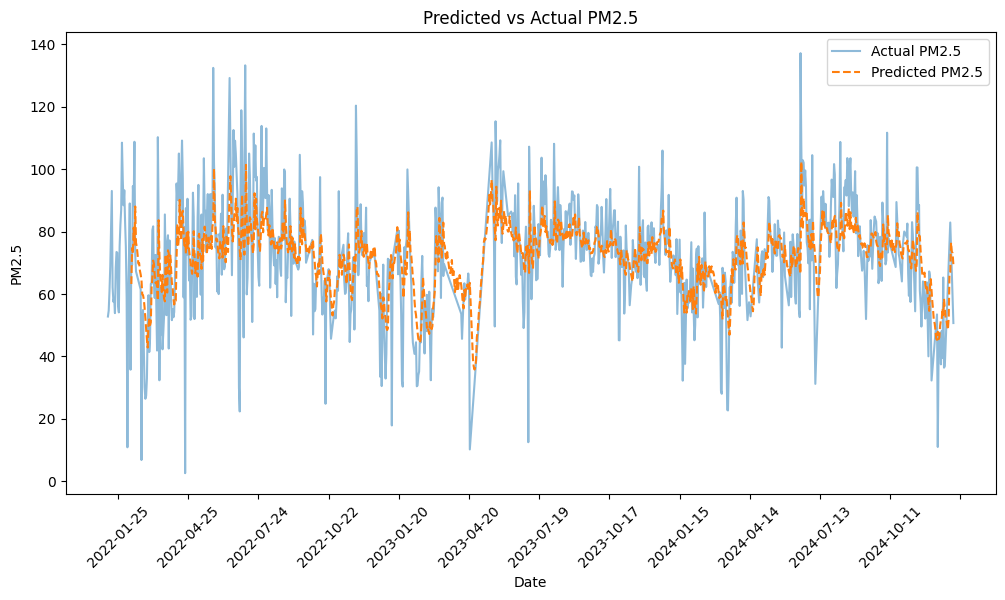

In [23]:
# Membuat generator data untuk prediksi
full_gen = TimeseriesGenerator(df_scaled, df_scaled[:, 6], length=lookback, batch_size=4)

# Melakukan prediksi
predictions = best_model.predict(full_gen)

# Membuat array nol dengan jumlah fitur yang sesuai untuk inverse_transform
num_features = len(features)  # Jumlah fitur yang digunakan saat normalisasi
dummy_array = np.zeros((len(predictions), num_features))  # Array nol dengan jumlah fitur yang sama
dummy_array[:, -1] = predictions.flatten()  # Menempatkan prediksi di kolom terakhir (PM2.5)

# Konversi kembali ke skala aslinya
pm25_predictions = scaler.inverse_transform(dummy_array)[:, -1]

# Membuat DataFrame hasil prediksi
prediction_dates = df["datetime"][lookback:].reset_index(drop=True)
pred_df = pd.DataFrame({"datetime": prediction_dates, "Predicted PM2.5": pm25_predictions})

# Plot hasil prediksi vs aktual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["ISPU PM2.5"], label="Actual PM2.5", alpha=0.5)
plt.plot(pred_df["datetime"], pred_df["Predicted PM2.5"], label="Predicted PM2.5", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("Predicted vs Actual PM2.5")
import matplotlib.dates as mdates
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90)) 
plt.legend()
plt.show()




In [24]:
df_results.to_csv("jagakarsa results.csv", index=False)

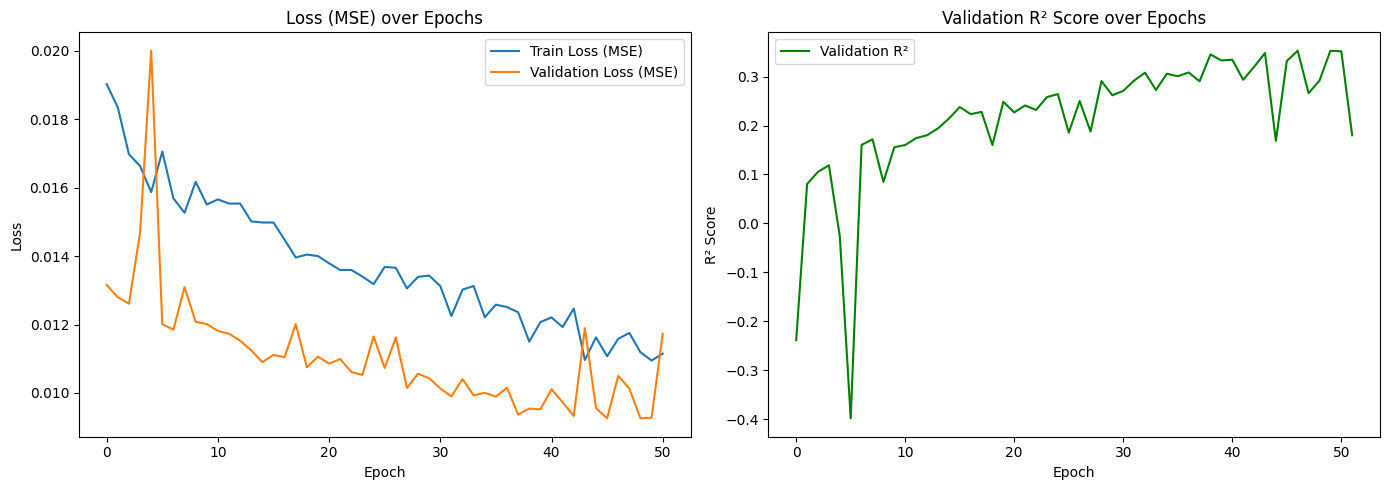

In [25]:
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
r2_scores = best_r2_callback.r2_scores

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss (MSE)')
plt.plot(val_loss, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (MSE) over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r2_scores, label='Validation R²', color='green')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

**8. Visualisasi Performa Pelatihan Model**

    Bagian ini menampilkan **performa model LSTM selama pelatihan** menggunakan dua metrik utama:

    1. **Loss (MSE)** — untuk menilai seberapa baik model mempelajari pola data.
    2. **R² Score** — untuk melihat kekuatan hubungan antara prediksi dan nilai aktual.

**1. Kurva Loss**
- Garis biru menunjukkan *training loss*, sedangkan garis merah menunjukkan *validation loss*.
- Garis vertikal titik-titik menandai *epoch* dengan **nilai loss minimum** untuk masing-masing.
- Pola divergensi antara *train* dan *validation loss* membantu mendeteksi potensi **overfitting**.

**2. Kurva R² (atau Alternatif Loss Ratio)**
- Jika callback `R²` tersedia, grafik menampilkan **perubahan skor R² selama epoch**.  
  Nilai R² tertinggi ditandai dengan anotasi “Max R²”.
- Jika tidak tersedia, grafik menampilkan **rasio loss** antara *validation* dan *training*,  
  dengan garis merah (ideal = 1) sebagai acuan kestabilan model.

**3. Ringkasan Kinerja**
Output konsol menampilkan:
- Epoch terakhir dan jumlah total pelatihan.  
- Nilai terbaik *training* dan *validation loss*.  
- R² tertinggi (jika tersedia).  
- Indikator potensi **overfitting** berdasarkan rasio *validation vs training loss*.

Visualisasi ini memberikan gambaran menyeluruh tentang **stabilitas dan generalisasi model LSTM** selama proses pelatihan.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract training history
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']

# Check if R2 scores are available
if hasattr(best_r2_callback, 'r2_scores'):
    r2_scores = best_r2_callback.r2_scores
else:
    # Fallback: create dummy R2 scores or skip
    r2_scores = None

# Create improved visualization
plt.figure(figsize=(15, 6))

# Plot 1: Loss curves with enhanced styling
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss (MSE)', color='#2E86AB', linewidth=2.5, alpha=0.8, marker='o', markersize=4, markevery=5)
plt.plot(val_loss, label='Validation Loss (MSE)', color='#A23B72', linewidth=2.5, alpha=0.8, marker='s', markersize=4, markevery=5)

# Add min loss annotations
min_train_epoch = np.argmin(loss)
min_val_epoch = np.argmin(val_loss)

plt.axvline(x=min_train_epoch, color='#2E86AB', linestyle=':', alpha=0.7, label=f'Min Train Loss (Epoch {min_train_epoch+1})')
plt.axvline(x=min_val_epoch, color='#A23B72', linestyle=':', alpha=0.7, label=f'Min Val Loss (Epoch {min_val_epoch+1})')

plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
plt.title('Model Loss over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Plot 2: R² scores with enhanced styling
plt.subplot(1, 2, 2)
if r2_scores is not None and len(r2_scores) > 0:
    plt.plot(r2_scores, label='Validation R²', color='#F18F01', linewidth=2.5, alpha=0.8, marker='^', markersize=5, markevery=5)
    
    # Add baseline and max R² annotations
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.6, linewidth=1, label='Baseline (R²=0)')
    
    max_r2_epoch = np.argmax(r2_scores)
    max_r2_value = r2_scores[max_r2_epoch]
    
    plt.axvline(x=max_r2_epoch, color='#F18F01', linestyle=':', alpha=0.7, label=f'Max R² (Epoch {max_r2_epoch+1})')
    
    # Annotation for max R²
    plt.annotate(f'Max R²: {max_r2_value:.4f}', 
                xy=(max_r2_epoch, max_r2_value), 
                xytext=(max_r2_epoch-5 if max_r2_epoch > 5 else max_r2_epoch+2, max_r2_value-0.15),
                arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))
    
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('R² Score', fontsize=12, fontweight='bold')
    plt.title('Validation R² Score over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
else:
    # If R² scores not available, show alternative plot
    plt.text(0.5, 0.5, 'R² Scores Not Available\n\nAlternative: Loss Ratio', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
    
    # Plot loss ratio instead
    loss_ratio = [val/train if train > 0 else 0 for train, val in zip(loss, val_loss)]
    plt.plot(loss_ratio, label='Val/Train Loss Ratio', color='purple', linewidth=2)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.6, label='Ideal Ratio = 1')
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss Ratio (Val/Train)', fontsize=12, fontweight='bold')
    plt.title('Validation/Training Loss Ratio', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print concise summary
print(f"\n📊 TRAINING PERFORMANCE SUMMARY")
print(f"{'='*40}")
print(f"🏁 Final Epoch: {len(loss)}")
print(f"📉 Best Training Loss: {min(loss):.6f}")
print(f"📊 Best Validation Loss: {min(val_loss):.6f}")
if r2_scores is not None:
    print(f"🎯 Best R² Score: {max(r2_scores):.6f} ({max(r2_scores)*100:.2f}%)")
print(f"⚖️  Overfitting Indicator: {'Yes' if min(val_loss) > min(loss) * 1.1 else 'No'}")